# Text Mining for ESG Score Analysis & Prediction : Using News data

## Import libraries

In [48]:
import sklearn
import random
import numpy as np
import pandas as pd
import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image #image 불러오기
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from collections import Counter

import re
import requests
#KoNLPy 공식 문서 : https://konlpy.org/ko/latest/
#설치되었는지 확인 : pip install konlpy
try:
  from konlpy.tag import Hannanum, Kkma, Komoran, Okt
except:
  !pip install konlpy
  from konlpy.tag import Hannanum, Kkma, Komoran, Okt

try:
  from kneed import KneeLocator
except:
  !pip install --upgrade kneed
  from kneed import KneeLocator

from sklearn.feature_extraction.text import TfidfVectorizer

np.random.seed(42)
%matplotlib inline

In [2]:
#access Google drive file
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [4]:
#한글 폰트 적용
try:
  mpl.rc('font', family='NanumBarunGothic')
  sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='whitegrid')
except:
  !sudo apt-get install -y fonts-nanum
  !sudo fc-cache -fv
  !rm ~/.cache/matplotlib -rf
  mpl.rc('font', family='NanumBarunGothic')
  sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='whitegrid')

In [5]:
# 그림 저장
image_path = '/content/drive/MyDrive/LIS3821/images/'

def save_fig(fig_name, tight_layout=True, fig_extension="png", resolution=300):
    #해상도 dpi=300
    path = image_path + fig_name + "." + fig_extension
    print("그림 저장: ", fig_name)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## ESG키워드 데이터 가져오기

In [6]:
path = '/content/drive/MyDrive/LIS3821/datasets/environment_keyword_250.txt'

with open(path, 'r') as f:
    e_keywords = f.read().splitlines()

e_keywords[:10]

['환경', '경영', '환경성', '정보', '관리', '제품', '평가', '이해관계자', '생산', '구축']

In [7]:
path = '/content/drive/MyDrive/LIS3821/datasets/social_keyword_250.txt'

with open(path, 'r') as f:
    s_keywords = f.read().splitlines()

s_keywords[:10]

['사회', '지역', '근로자', '소비자', '제품', '제공', '협력', '거래', '정보', '행위']

In [8]:
path = '/content/drive/MyDrive/LIS3821/datasets/governance_keyword_250.txt'

with open(path, 'r') as f:
    g_keywords = f.read().splitlines()

g_keywords[:10]

['감사', '위원회', '이사회', '주주', '경영', '이사', '사외이사', '정보', '지배구조', '외부']

## Preprocessing

In [200]:
#한전기술
df_kepco_2019 = pd.read_csv('/content/drive/MyDrive/LIS3821/datasets/News/News_한전기술_2019.CSV', encoding='utf-8')
df_kepco_2019.head(3)

,뉴스 식별자,일자,언론사,기고자,제목,통합 분류1,통합 분류2,통합 분류3,사건/사고 분류1,사건/사고 분류2,사건/사고 분류3,인물,위치,기관,키워드,특성추출(가중치순 상위 50개),본문,URL,분석제외 여부
0,2.100801e+06,20191231,아시아경제,문채석,"한국전력기술, 업(業)연계 中企 에너지 효율화 진단 실무협약 체결",지역>충남,지역>경기,지역>울산,NaN,NaN,NaN,"민,윤상영,민경학","경북,신사업관리실장,김천,신사업본부,김천시","김천상공회의소,박찬융 김천상공회의소,김천시청","한국전력기술,연계,中企,에너지,효율,진단,실무,협약,체결,한국전력기술,김천,경북,김...","한국전력기술,중소기업,김천상공회의소,일자리,관계자,김천,박찬융,김천시청,민경학,윤상...","[아시아경제 문채석 기자]한국전력기술은 30일 경북 김천 본사에서 김천시, 김천상공...",http:www.asiae.co.kr/article/2019123108045535897,NaN
1,1.500701e+06,20191230,부산일보,송현수,"한전기술, 업(業)연계 중기 에너지 효율화 진단 실무협약 ?",지역>충남,경제>산업_기업,지역>경기,NaN,NaN,NaN,"윤상영,민경학","경북,김천,신사업관리실,신사업본부,김천시","김천상공회의소,김천시청,김천상공회의소 박찬융","한전기술,연계,실무협약,중기,에너지,효율,진단,실무,협약,공공기관,중기,中企,상생발...","한국전력기술,중소기업,민경학,김천상공회의소,상생발전,김천시,박찬융,협약식,공공기관,...",한국전력기술은 30일 업(業)연계 중기 에너지 효율화 진단 실무협약을 체결했다.(왼...,http://www.busan.com/view/busan/view.php?code=...,NaN
2,1.500701e+06,20191230,부산일보,송현수,"한전기술, 협력사와 지식재산권 실시허여 협약식",경제>산업_기업,경제>자동차,NaN,NaN,NaN,NaN,"이배수,진태은","서울,오크우드호텔",NaN,"한전기술,협력사,지식재산권,협약식,자체,무상제공,한국전력기술,협력,회사,지식재산권,...","협력회사,원자력,지식재산권,한국전력기술,협약식,사용권,진태,협력사,서울,한전,한전기...",한국전력기술은 지난 27일 협력회사와 지식재산권 실시허여 협약식을 가졌다. 한전기술...,http://www.busan.com/view/busan/view.php?code=...,NaN


In [201]:
#한전기술
df_kepco_2020 = pd.read_csv('/content/drive/MyDrive/LIS3821/datasets/News/News_한전기술_2020.CSV', encoding='utf-8')
df_kepco_2020.head(3)

,뉴스 식별자,일자,언론사,기고자,제목,통합 분류1,통합 분류2,통합 분류3,사건/사고 분류1,사건/사고 분류2,사건/사고 분류3,인물,위치,기관,키워드,특성추출(가중치순 상위 50개),본문,URL,분석제외 여부
0,1.100901e+06,20201231,중앙일보,NaN,"희망조약돌 이재원 이사장, 2020 대한민국 공공정책대상 '시민사회단체부문' 수상",지역>대전,정치>국회_정당,정치>선거,NaN,NaN,NaN,"김창준,홍정민,김선녀,박종래,박종환,정찬민,양향자,김승남,유덕열,남영희,이재원,김승...","한국사회공헌협회,김해시,정읍시,서울,순천시의원,전남도의원,대구시의원,한국공공정책학회...","양천구청장,KB국민은행,강남삼성성형외,동대문구청,미래한미재단,독립기념관,한국공공정책...","이사장,희망,조약돌,이재원,대한민국,공공,정책,대상,시민,사회단체,수상,이사장,구호...","더불어민주당,국회의원,대한민국,서울,이재원,이사장,서울시,위원장,한국공공정책학회,미...",국내구호전문 사단법인 희망조약돌 이재원 이사장은 한국공공정책학회가 주관한 「제5회 ...,https://www.joongang.co.kr/article/23959288,NaN
1,1.101101e+06,20201230,한국일보,NaN,[인사] 헌법재판소 외,경제>산업_기업,경제>취업_창업,NaN,범죄>기업범죄>내부자거래,NaN,NaN,"류병옥,안범진,최진혁,박석희,최종천,박찬용,김정균,허원제,안병환,조현찬,이진균,김명...","△인천지역본부장,경기남부,△광주지사장,경기,성남지역,태백검사,창우,상주교통안전체험교...","헌법재판연구원,한국농촌경제연구원,CIS기술실,충북본부장,△대구경북본부장,산업안전,국...","헌법재판소,헌법,재판소,승진,전보,심판,지원,실장,정원국,국제,협력,국장,석현철,도...","본부장,팀장,센터장,지사장,파트장,교육부,연구부,서울,화폐본부,대우,2급,정치부,자...",◆헌법재판소 <승진> △심판지원실장 정원국 △국제협력국장 석현철 △도서심의관 지인수...,https://hankookilbo.com/News/Read/A20201230173...,예외
2,7.101201e+06,20201230,디지털타임스,김승룡,[인사] 한국전력기술,지역>울산,지역>경기,지역>전북,NaN,NaN,NaN,"김태웅,이정훈,김일배,이덕수,유성호,이주열,전성환,정환용,임호재","지신사업처장,토건환경기술실장",한국전력기술,"한국전력기술,인사,한국전력기술,직할부,스마트,융합실장,장현영,디지털,엔지니어링,실장...","이상배,정환용,이덕수,김일배,김태웅,장현영,임호재,원자로,여인선,이주열,그룹장,에너...",[인사] 한국전력기술\n\n\n\n◇직할부서 ▲스마트융합실장 장현영 ▲디지털엔지니어...,http://www.dt.co.kr/contents.html?article_no=2...,예외


In [202]:
#한전기술
df_kepco_2021 = pd.read_csv('/content/drive/MyDrive/LIS3821/datasets/News/News_한전기술_2021.CSV', encoding='utf-8')
df_kepco_2021.head(3)

,뉴스 식별자,일자,언론사,기고자,제목,통합 분류1,통합 분류2,통합 분류3,사건/사고 분류1,사건/사고 분류2,사건/사고 분류3,인물,위치,기관,키워드,특성추출(가중치순 상위 50개),본문,URL,분석제외 여부
0,1.100611e+06,20211231,서울신문,임송학,새만금에 국가 종합 신재생에너지 실증연구단지 구축,지역>경기,경제>자원,지역>대전,NaN,NaN,NaN,NaN,"전북도,실증단지,업단,새만금,새만금지구,군산시,연구단지","연구단,전북도,기재부,전북지사,한국에너지기술평가원,한국전력기술(주),한양대학교,재생...","새만금,신재생,국가,종합,신재,에너지,실증,단지,구축,2025년,투입,5만,규모,조...","새만금,사업비,실증연구단지,디지털트윈,전북도,실증간,관계기관,송하진,태양광,기재부,...",재생에너지 국가종합 실증연구단지가 새만금지구에 들어선다.\n전북도는 새만금 국가종합...,http://www.seoul.co.kr/news/newsView.php?id=20...,NaN
1,2.100201e+06,20211231,머니투데이,이상수|MTN PD,[여의도 클라쓰] SMR 원천기술 보유 '한전기술'ㆍ비건설 구조적 변화 '삼성물산',미분류,NaN,NaN,NaN,NaN,NaN,NaN,"원천,신사,경기","삼성물산,머니투데이방송,유일,어드바이저,한전기술,SMR,EU 그린택소노미,후쿠시마","SMR,원천,보유,한전기술,비건설,삼성물산,구조,변화,앵커,양도세,분들,내년,법안,...","한전기술,클라쓰,삼성물산,서동구,그린택소노미,섹터,원자력,나영호,유망주,비건설,신재...","[머니투데이 이상수 MTN PD] \n▶▶▶ 앵커의 눈\n""자자, 양도세 피한 분들...",http://news.moneytoday.co.kr/view/mtview.php?n...,NaN
2,8.100101e+06,20211231,KBS,박재홍,새만금 국가종합실증연구단지 구축 협약 ‘2025년까지 추진’,지역>대전,경제>경제일반,지역>충남,NaN,NaN,NaN,NaN,"새만금,전라북도,군산시,연구단지","연구단,한국전력기술,한국에너지기술평가원","2025년,새만금,국가,종합실증,단지,구축,협약,추진,전라북도,군산시,한국에너지기술...","새만금,태양광,방조제,제곱미터,고용창출,한국전력기술,한국에너지기술평가원,군산시,기업...","[KBS 전주]\n전라북도와 군산시, 한국에너지기술평가원, 한국전력기술 등 십여 개...",https://news.kbs.co.kr/news/view.do?ncd=536153...,NaN


In [203]:
df_kepco = pd.concat([df_kepco_2019, df_kepco_2020, df_kepco_2021], ignore_index=True)

df_kepco.tail(3)

,뉴스 식별자,일자,언론사,기고자,제목,통합 분류1,통합 분류2,통합 분류3,사건/사고 분류1,사건/사고 분류2,사건/사고 분류3,인물,위치,기관,키워드,특성추출(가중치순 상위 50개),본문,URL,분석제외 여부
2440,1.500601e+06,20210106,매일신문,홍준헌,대구경북 상장 기업 시총 1년 새 10조원 늘었다,경제>증권_증시,경제>금융_재테크,경제>자동차,NaN,NaN,NaN,NaN,"방산,미국,신사,중국,경기,대구경북","한국거래소,미국,경기,한국,POSCO,한화시스템 ▷대성홀딩스,유가증권,명신산업,남선...","1년,대구경북,상장,기업,시총,10조,상장사,45조,방역,성과,백신,글로벌,투자자,...","시총,코스피,대구경북,상장사,포스코,전기차,1조,포스코케미칼,한화시스템,남선알미늄,...",코스피(유가증권시장) 3천 시대를 눈앞에 둔 가운데 대구경북 코스피 상장사들 시가총...,https://news.imaeil.com/Economy/20210106181225...,NaN
2441,2.100201e+06,20210105,머니투데이,세종=민동훈|기자,올봄 임기 만료되는 공공기관장 인사 큰장 선다,경제>산업_기업,정치>청와대,NaN,NaN,NaN,NaN,"박일준,양수영,유향열,김병숙,김종갑,조성완,성윤모,박형구,성,정재훈,문재인,이배수,...","한국남,하마평,월성","한국생산성본부,한국수력원자력,남동발전,정부,임원추천위원회,한국전력공사,한국광물자원공...","만료,올봄,임기,공공기관장,인사,큰장,선다,새해,임기,만료,산업통상,자원부,산하,에...","산업부,한전,공공기관장,만큼,공기업,기관장,문재인,공공기관,수원",[머니투데이 세종=민동훈 기자] 새해 임기가 만료되는 산업통상자원부 산하 에너지 공...,http://news.moneytoday.co.kr/view/mtview.php?n...,NaN
2442,1.400701e+06,20210104,충청투데이,이정훈 기자,"대전여상, 공공기관 합격자 14명 배출",경제>취업_창업,지역>울산,지역>충북,NaN,NaN,NaN,"유예진,조수민,홍정훈","대전여자상업고,회계","국가철도공단,KDB산업은행,한국전력기술,한국국제협력단,KOICA,대전시교육청,LH토...","대전여상,공공,기관,합격자,배출,대전시교육청,대전여자상업고,재학,유예진,조수민,2명...","1명,대전여상,2명,공공기관,홍정훈,합격자,대전여자상업고,한국국제협력단,학생들,한국...","[충청투데이 이정훈 기자] 대전시교육청은 대전여자상업고 3학년에 재학 중인 유예진,...",http://www.cctoday.co.kr/news/articleView.html...,NaN


In [204]:
df_kepco.columns

Index(['뉴스 식별자', '일자', '언론사', '기고자', '제목', '통합 분류1', '통합 분류2', '통합 분류3',
       '사건/사고 분류1', '사건/사고 분류2', '사건/사고 분류3', '인물', '위치', '기관', '키워드',
       '특성추출(가중치순 상위 50개)', '본문', 'URL', '분석제외 여부'],
      dtype='object')

In [205]:
df_kepco = df_kepco[['일자', '제목', '키워드']]
df_kepco.tail(3)

,일자,제목,키워드
2440,20210106,대구경북 상장 기업 시총 1년 새 10조원 늘었다,"1년,대구경북,상장,기업,시총,10조,상장사,45조,방역,성과,백신,글로벌,투자자,..."
2441,20210105,올봄 임기 만료되는 공공기관장 인사 큰장 선다,"만료,올봄,임기,공공기관장,인사,큰장,선다,새해,임기,만료,산업통상,자원부,산하,에..."
2442,20210104,"대전여상, 공공기관 합격자 14명 배출","대전여상,공공,기관,합격자,배출,대전시교육청,대전여자상업고,재학,유예진,조수민,2명..."


In [206]:
#열 이름 변경
df_kepco.columns = ['date', 'title', 'keyword',]

In [207]:
df_kepco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2443 entries, 0 to 2442
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     2443 non-null   int64 
 1   title    2443 non-null   object
 2   keyword  2443 non-null   object
dtypes: int64(1), object(2)
memory usage: 57.4+ KB


In [208]:
#연도만 추출
df_kepco['date'] = df_kepco['date'].apply(lambda x : int(x//10000))

In [209]:
df_kepco

,date,title,keyword
0,2019,"한국전력기술, 업(業)연계 中企 에너지 효율화 진단 실무협약 체결","한국전력기술,연계,中企,에너지,효율,진단,실무,협약,체결,한국전력기술,김천,경북,김..."
1,2019,"한전기술, 업(業)연계 중기 에너지 효율화 진단 실무협약 ?","한전기술,연계,실무협약,중기,에너지,효율,진단,실무,협약,공공기관,중기,中企,상생발..."
2,2019,"한전기술, 협력사와 지식재산권 실시허여 협약식","한전기술,협력사,지식재산권,협약식,자체,무상제공,한국전력기술,협력,회사,지식재산권,..."
3,2019,한국전력기술 협력사와 지식재산권 실시허여 협약 체결,"한국전력기술,협력사,지식재산권,협약,체결,한국전력기술,사장,이배수,오크우드호텔,서울..."
4,2019,"한국테크놀로지, +3.37% 52주 신고가","한국테크놀로지,신고가,3.37%,한국테크놀로지,신고가,경신,전일,대비,3.37%,상..."
...,...,...,...
2438,2021,한국전력기술 디지털엔지니어링 전담조직 구축,"한국전력기술,디지,털엔지니어링,전담,조직,구축,한국전력기술,한국판,뉴딜,추진,데이터..."
2439,2021,"""코로나 위기 뚫고 취업 성공했어요""","코로나,위기,취업,성공,코로나19,코로나,취업난,지역,학생,취업,열기,대전여자상업고..."
2440,2021,대구경북 상장 기업 시총 1년 새 10조원 늘었다,"1년,대구경북,상장,기업,시총,10조,상장사,45조,방역,성과,백신,글로벌,투자자,..."
2441,2021,올봄 임기 만료되는 공공기관장 인사 큰장 선다,"만료,올봄,임기,공공기관장,인사,큰장,선다,새해,임기,만료,산업통상,자원부,산하,에..."


In [210]:
#'keyword' 열 값 String에서 List로 변환
df_kepco['keyword'] = df_kepco['keyword'].str.split(',')

In [211]:
df_kepco['keyword']

0       [한국전력기술, 연계, 中企, 에너지, 효율, 진단, 실무, 협약, 체결, 한국전력...
1       [한전기술, 연계, 실무협약, 중기, 에너지, 효율, 진단, 실무, 협약, 공공기관...
2       [한전기술, 협력사, 지식재산권, 협약식, 자체, 무상제공, 한국전력기술, 협력, ...
3       [한국전력기술, 협력사, 지식재산권, 협약, 체결, 한국전력기술, 사장, 이배수, ...
4       [한국테크놀로지, 신고가, 3.37%, 한국테크놀로지, 신고가, 경신, 전일, 대비...
                              ...                        
2438    [한국전력기술, 디지, 털엔지니어링, 전담, 조직, 구축, 한국전력기술, 한국판, ...
2439    [코로나, 위기, 취업, 성공, 코로나19, 코로나, 취업난, 지역, 학생, 취업,...
2440    [1년, 대구경북, 상장, 기업, 시총, 10조, 상장사, 45조, 방역, 성과, ...
2441    [만료, 올봄, 임기, 공공기관장, 인사, 큰장, 선다, 새해, 임기, 만료, 산업...
2442    [대전여상, 공공, 기관, 합격자, 배출, 대전시교육청, 대전여자상업고, 재학, 유...
Name: keyword, Length: 2443, dtype: object

In [262]:
#불용어
stopwords = ['한국전력기술', '한전기술', '한전', '한전', '기술', '기자', '실시간', '지난달',
             '한수원','한국수력원자력', '두산중공업','이배수','한전kps','거래량','한국전력',]

In [263]:
#정규식 사용해 특수문자 및 숫자, 1음절 제거
def cleaned(text):
  cleaned_text = ''
  text = re.sub(r'[^A-Za-z가-힣]',"",text) #한글, 영어만 가져오기
  # text = re.sub(r'\d+', "", text) #숫자 제거
  if (len(text) > 2) & (text not in stopwords):
    #2음절 이상 & not 불용어
    cleaned_text = text

  return cleaned_text

In [264]:
cleaned_keywords = []
cleaned_keyword_all = []

for keyword_list in df_kepco['keyword']:
  for keyword in keyword_list:
    keyword = cleaned(keyword)
    cleaned_keywords.append(keyword)
  
  cleaned_keyword_all.append(' '.join(cleaned_keywords).split()) #빈값 제외하고 append
  cleaned_keywords = []

df_kepco['keyword'] = cleaned_keyword_all

In [265]:
df_kepco['keyword']

0       [에너지, 김천시, 김천상공회의소, 실무협약, 에너지, 중소기업, 에너지, 설비개선...
1       [실무협약, 에너지, 공공기관, 상생발전, 실무협약, 에너지, 민경학, 김천시, 윤...
2       [협력사, 지식재산권, 협약식, 무상제공, 지식재산권, 협약식, 오크우드호텔, 원자...
3       [협력사, 지식재산권, 오크우드호텔, 원자력본부장, 대표자, 협약식, 지식재산권, ...
4       [한국테크놀로지, 신고가, 한국테크놀로지, 신고가, 한국테크놀로지, 한전KPS, 우...
                              ...                        
2438    [털엔지니어링, 한국판, 데이터, 프로젝트, 디지털화, 엔지니어링, 디지털, 엔지니...
2439    [코로나, 코로나, 코로나, 취업난, 대전여자상업고등학교, 대전여상, 재학중, 유예...
2440    [대구경북, 상장사, 글로벌, 투자자, 투자자, 포스코, 포스코케미칼, 가스공사, ...
2441    [공공기관장, 산업통상, 자원부, 에너지, 기관장, 성윤모, 산업부, 조직개편, 산...
2442    [대전여상, 합격자, 대전시교육청, 대전여자상업고, 유예진, 조수민, 한국국제협력단...
Name: keyword, Length: 2443, dtype: object

In [266]:
#keyword list 생성
kepco_keyword_list = [" ".join(keyword) for keyword in df_kepco['keyword']]

In [267]:
#상위 빈도수 단어
counter = Counter([y for x in df_kepco['keyword'] for y in x])
counter.most_common(20)

[('원자력', 2560),
 ('에너지', 2072),
 ('공기업', 1039),
 ('코로나', 823),
 ('발전소', 748),
 ('UAE', 687),
 ('탈원전', 658),
 ('공공기관', 547),
 ('관계자', 530),
 ('일자리', 516),
 ('한전KPS', 478),
 ('APR', 457),
 ('외국인', 451),
 ('프로그램', 438),
 ('위원회', 417),
 ('중소기업', 408),
 ('정재훈', 399),
 ('본부장', 391),
 ('원자로', 379),
 ('코스피', 361)]

In [268]:
#ESG 키워드 띄어씌기로 구분하여 이어 붙이기
esg_keywords = []
esg_keywords.append(' '.join(e_keywords))
esg_keywords.append(' '.join(s_keywords))
esg_keywords.append(' '.join(g_keywords))

In [269]:
df_kepco_keywords = pd.DataFrame({'keywords' : []})
df_kepco_keywords['keywords'] = kepco_keyword_list

df_kepco_keywords

,keywords
0,에너지 김천시 김천상공회의소 실무협약 에너지 중소기업 에너지 설비개선 효율적 중소기...
1,실무협약 에너지 공공기관 상생발전 실무협약 에너지 민경학 김천시 윤상영 사무국장 김...
2,협력사 지식재산권 협약식 무상제공 지식재산권 협약식 오크우드호텔 원자력본부장 대표자...
3,협력사 지식재산권 오크우드호텔 원자력본부장 대표자 협약식 지식재산권 소프트웨어 EP...
4,한국테크놀로지 신고가 한국테크놀로지 신고가 한국테크놀로지 한전KPS 우리기술 에너토...
...,...
2438,털엔지니어링 한국판 데이터 프로젝트 디지털화 엔지니어링 디지털 엔지니어링 디지털엔지...
2439,코로나 코로나 코로나 취업난 대전여자상업고등학교 대전여상 재학중 유예진 박지현 조수...
2440,대구경북 상장사 글로벌 투자자 투자자 포스코 포스코케미칼 가스공사 코스피 유가증권시...
2441,공공기관장 산업통상 자원부 에너지 기관장 성윤모 산업부 조직개편 산업부 산업통상 자...


In [270]:
#ESG 키워드 리스트랑 기업뉴스 키워드 리스트 합치기
keywords_all = esg_keywords + kepco_keyword_list

In [271]:
#TF-IDF를 이용한 Feature extraction
#sublinear_tf 파라미터는 TF (Term-Frequency, 단어빈도) 값의 스무딩(smoothing) 여부를 결정하는 파라미터 입니다. (True/False)
#'TF 값에 대해 아웃라이어 처리를 해준다'라는 효과
#자연어처리 데이터를 다루다보면, 엄청 긴 데이터를 만날 수 있습니다.
#예를 들어서 다른 데이터의 단어들은 10정도를 가지는데, 어떤 데이터만 단어 종류가 100이 넘어간다고 하면, 
#이 100에 맞추어 feature의 수가 엄청 늘어나게 됩니다. 그럴 경우, 모델 성능이 저하될 수도 있는 것이죠.

tfidf = TfidfVectorizer(analyzer = 'word', sublinear_tf=True, max_df = 0.95, max_features=100)
X = tfidf.fit_transform(kepco_keyword_list)

In [272]:
df_tfidf = pd.DataFrame(X.toarray(), columns = sorted(tfidf.vocabulary_))
df_tfidf.head()

,apr,epc,iter,lng,mou,smr,uae,가능성,간담회,경북도,...,한국동서발전,한국마사회,한국원자력연구원,한국전력공사,한국중부발전,한전kdn,한전kps,한전원자력연료,현대건설,활성화
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.388084,0.0,0.0,0.0


In [273]:
#가중치 높은 순
keyword_df = pd.DataFrame(df_tfidf.sum().sort_values(ascending=False))
keyword = keyword_df.index.tolist()
keyword[:20]

['원자력',
 '에너지',
 '공기업',
 '코로나',
 '공공기관',
 '발전소',
 '관계자',
 '한전kps',
 '매출액',
 '탈원전',
 '코스피',
 '위원회',
 '프로그램',
 '본부장',
 '자회사',
 '한전원자력연료',
 '부친상',
 '일자리',
 'uae',
 '중소기업']

# ESG 키워드와의 유사도 확인

In [274]:
matrix = tfidf.fit_transform(keywords_all)

In [275]:
from sklearn.metrics.pairwise import cosine_similarity
cos_similar = cosine_similarity(matrix,matrix)
print("\nCosine Similarity\n")
df_tfidf_esg = pd.DataFrame(cos_similar)
df_tfidf_esg.rename(columns={0 : 'doc_e', 1:'doc_s', 2: 'doc_g'}, inplace=True)
df_tfidf_esg = df_tfidf_esg.loc[3:].reset_index(drop=True)
df_tfidf_esg
#doc0 ~ doc2443


Cosine Similarity



,doc_e,doc_s,doc_g,3,4,5,6,7,8,9,...,2436,2437,2438,2439,2440,2441,2442,2443,2444,2445
0,0.172175,0.000000,0.000000,1.000000,0.974719,0.000000,0.000000,0.000000,0.000000,0.0000,...,0.118378,0.293330,0.098112,0.133167,0.085300,0.099676,0.118579,0.030565,0.179432,0.263891
1,0.165224,0.000000,0.000000,0.974719,1.000000,0.000000,0.000000,0.000000,0.000000,0.0000,...,0.113599,0.266234,0.094151,0.121923,0.081856,0.095652,0.169439,0.025795,0.195744,0.377078
2,0.000000,0.000000,0.158344,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.2596,...,0.098229,0.128569,0.067768,0.056945,0.000000,0.068849,0.000000,0.000000,0.046884,0.000000
3,0.000000,0.000000,0.158344,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.2596,...,0.098229,0.128569,0.067768,0.056945,0.000000,0.068849,0.000000,0.000000,0.046884,0.000000
4,0.000000,0.000000,0.344857,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045485,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2438,0.098326,0.369595,0.000000,0.099676,0.095652,0.068849,0.068849,0.000000,0.000000,0.0000,...,0.872429,0.092216,0.965017,0.965805,0.936580,1.000000,0.000000,0.000000,0.066452,0.000000
2439,0.000000,0.000000,0.000000,0.118579,0.169439,0.000000,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.130753,0.135287,0.000000,1.000000,0.206847,0.096776,0.449346
2440,0.000000,0.000000,0.183892,0.030565,0.025795,0.000000,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.156155,0.000000,0.033888,0.035063,0.000000,0.206847,1.000000,0.014733,0.000000
2441,0.181320,0.000000,0.046290,0.179432,0.195744,0.046884,0.046884,0.045485,0.114801,0.0000,...,0.081746,0.113423,0.065409,0.054962,0.046753,0.066452,0.096776,0.014733,1.000000,0.215370


In [276]:
df_tfidf_esg = df_tfidf_esg[['doc_e','doc_s', 'doc_g']]

In [277]:
max_similarity = df_tfidf_esg.max(axis=1)
max_similarity

0       0.172175
1       0.165224
2       0.158344
3       0.158344
4       0.344857
          ...   
2438    0.369595
2439    0.000000
2440    0.183892
2441    0.181320
2442    0.000000
Length: 2443, dtype: float64

In [278]:
max_idx = df_tfidf_esg.idxmax(axis=1)
max_idx

0       doc_e
1       doc_e
2       doc_g
3       doc_g
4       doc_g
        ...  
2438    doc_s
2439    doc_e
2440    doc_g
2441    doc_e
2442    doc_e
Length: 2443, dtype: object

In [279]:
df_esg_max_similarity = pd.DataFrame({'doc_num' : list(range(len(kepco_keyword_list))), 'ESG': max_idx, 'similarity' : max_similarity})
df_esg_max_similarity

,doc_num,ESG,similarity
0,0,doc_e,0.172175
1,1,doc_e,0.165224
2,2,doc_g,0.158344
3,3,doc_g,0.158344
4,4,doc_g,0.344857
...,...,...,...
2438,2438,doc_s,0.369595
2439,2439,doc_e,0.000000
2440,2440,doc_g,0.183892
2441,2441,doc_e,0.181320


In [280]:
df_esg_max_similarity['ESG'].replace({'doc_e' : 'E', 'doc_s': 'S', 'doc_g':'G'}, inplace=True)

In [281]:
df_kepco_esg = pd.concat([df_kepco, df_esg_max_similarity], axis=1)
df_kepco_esg

,date,title,keyword,doc_num,ESG,similarity
0,2019,"한국전력기술, 업(業)연계 中企 에너지 효율화 진단 실무협약 체결","[에너지, 김천시, 김천상공회의소, 실무협약, 에너지, 중소기업, 에너지, 설비개선...",0,E,0.172175
1,2019,"한전기술, 업(業)연계 중기 에너지 효율화 진단 실무협약 ?","[실무협약, 에너지, 공공기관, 상생발전, 실무협약, 에너지, 민경학, 김천시, 윤...",1,E,0.165224
2,2019,"한전기술, 협력사와 지식재산권 실시허여 협약식","[협력사, 지식재산권, 협약식, 무상제공, 지식재산권, 협약식, 오크우드호텔, 원자...",2,G,0.158344
3,2019,한국전력기술 협력사와 지식재산권 실시허여 협약 체결,"[협력사, 지식재산권, 오크우드호텔, 원자력본부장, 대표자, 협약식, 지식재산권, ...",3,G,0.158344
4,2019,"한국테크놀로지, +3.37% 52주 신고가","[한국테크놀로지, 신고가, 한국테크놀로지, 신고가, 한국테크놀로지, 한전KPS, 우...",4,G,0.344857
...,...,...,...,...,...,...
2438,2021,한국전력기술 디지털엔지니어링 전담조직 구축,"[털엔지니어링, 한국판, 데이터, 프로젝트, 디지털화, 엔지니어링, 디지털, 엔지니...",2438,S,0.369595
2439,2021,"""코로나 위기 뚫고 취업 성공했어요""","[코로나, 코로나, 코로나, 취업난, 대전여자상업고등학교, 대전여상, 재학중, 유예...",2439,E,0.000000
2440,2021,대구경북 상장 기업 시총 1년 새 10조원 늘었다,"[대구경북, 상장사, 글로벌, 투자자, 투자자, 포스코, 포스코케미칼, 가스공사, ...",2440,G,0.183892
2441,2021,올봄 임기 만료되는 공공기관장 인사 큰장 선다,"[공공기관장, 산업통상, 자원부, 에너지, 기관장, 성윤모, 산업부, 조직개편, 산...",2441,E,0.181320


In [282]:
condition = (df_kepco_esg['similarity'] > 0.25)
df_kepco_esg = df_kepco_esg[condition]
df_kepco_esg

,date,title,keyword,doc_num,ESG,similarity
4,2019,"한국테크놀로지, +3.37% 52주 신고가","[한국테크놀로지, 신고가, 한국테크놀로지, 신고가, 한국테크놀로지, 한전KPS, 우...",4,G,0.344857
37,2019,"한전기술, +12.47% VI 발동","[테마한전기술, 한전KPS, 우리기술, 에너토크, 보성파워텍, 에스앤더블류, 오르비...",37,G,0.291934
39,2019,"'한전기술' 5% 이상 상승, 최근 5일간 기관 대량 순매수","[개인들, 외국인, 그동안, 순매도, 거래비중, 외국인, 투자자들, 그래프, 외국인...",39,G,0.327884
40,2019,"한전KPS, +0.74% 52주 신고가","[한전KPS, 신고가, 한전KPS, 신고가, KPS, 한전KPS, 우리기술, 에너토...",40,G,0.263742
45,2019,"한수원, 한전기술.원자력환경공단 등과 원전 분야 창업 지원 `맞손`","[원자력환경공단, 화백컨벤션센터, 컨벤션, 경북창조경제혁신센터, 한국원자력환경공단,...",45,E,0.297767
...,...,...,...,...,...,...
2432,2021,발전공기업?한전 그룹사 신임 사장 채용 스타트 1분기 9곳 교체 전망,"[발전공기업, 그룹사, 스타트, 발전공기업, 그룹사, 최고경영자, CEO, 발전공기...",2432,E,0.322276
2433,2021,"한전기술, 디지털엔지니어링실 만든다","[디지털엔지니어링실, 원자력, 에너지플랜트, 에너지, 플랜트, 한국전력기술이, 한국...",2433,S,0.311440
2435,2021,"한국전력기술, 디지털엔지니어링 전담팀 신설","[털엔지니어링, 데이터, 프로젝트, 디지털화, 엔지니어링, 한국판, 데이터, 프로젝...",2435,S,0.450914
2436,2021,"한전기술, '디지털 엔지니어링' 전담 조직 구축","[디지털, 엔지니어링, 엔지니어링산업, 디지털, 한국판, 디지털, 엔지니어링, 한국...",2436,S,0.305690


In [283]:
df_kepco_esg = df_kepco_esg.drop('doc_num', axis=1).drop('similarity', axis=1)
df_kepco_esg

,date,title,keyword,ESG
4,2019,"한국테크놀로지, +3.37% 52주 신고가","[한국테크놀로지, 신고가, 한국테크놀로지, 신고가, 한국테크놀로지, 한전KPS, 우...",G
37,2019,"한전기술, +12.47% VI 발동","[테마한전기술, 한전KPS, 우리기술, 에너토크, 보성파워텍, 에스앤더블류, 오르비...",G
39,2019,"'한전기술' 5% 이상 상승, 최근 5일간 기관 대량 순매수","[개인들, 외국인, 그동안, 순매도, 거래비중, 외국인, 투자자들, 그래프, 외국인...",G
40,2019,"한전KPS, +0.74% 52주 신고가","[한전KPS, 신고가, 한전KPS, 신고가, KPS, 한전KPS, 우리기술, 에너토...",G
45,2019,"한수원, 한전기술.원자력환경공단 등과 원전 분야 창업 지원 `맞손`","[원자력환경공단, 화백컨벤션센터, 컨벤션, 경북창조경제혁신센터, 한국원자력환경공단,...",E
...,...,...,...,...
2432,2021,발전공기업?한전 그룹사 신임 사장 채용 스타트 1분기 9곳 교체 전망,"[발전공기업, 그룹사, 스타트, 발전공기업, 그룹사, 최고경영자, CEO, 발전공기...",E
2433,2021,"한전기술, 디지털엔지니어링실 만든다","[디지털엔지니어링실, 원자력, 에너지플랜트, 에너지, 플랜트, 한국전력기술이, 한국...",S
2435,2021,"한국전력기술, 디지털엔지니어링 전담팀 신설","[털엔지니어링, 데이터, 프로젝트, 디지털화, 엔지니어링, 한국판, 데이터, 프로젝...",S
2436,2021,"한전기술, '디지털 엔지니어링' 전담 조직 구축","[디지털, 엔지니어링, 엔지니어링산업, 디지털, 한국판, 디지털, 엔지니어링, 한국...",S


In [284]:
#ESG keyword list 생성
kepco_esg_keyword_list = [" ".join(keyword) for keyword in df_kepco_esg['keyword']]

In [285]:
tfidf = TfidfVectorizer(analyzer = 'word', sublinear_tf=True, max_df = 0.95, max_features=100)
X = tfidf.fit_transform(kepco_esg_keyword_list)

In [286]:
df_tfidf = pd.DataFrame(X.toarray(), columns = sorted(tfidf.vocabulary_))
df_tfidf.head()

,cgv,hmm,nft,nice,smr,uae,가격대,가능성,거래비중,거래소,...,테마주,투자자,투자자들,폐기물,프로젝트,플랫폼,한국테크놀로지,한전kps,향우회,활성화
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.754298,0.232061,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.479573,0.385000,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.453285,0.0,...,0.0,0.0,0.383428,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.329979,0.632143,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.504897,0.000000,0.000000,0.0,0.352012


In [287]:
#가중치 높은 순
keyword_df = pd.DataFrame(df_tfidf.sum().sort_values(ascending=False))
keyword = keyword_df.index.tolist()
keyword[:20]

['에너지',
 '원자력',
 '프로젝트',
 '외국인',
 '활성화',
 '가능성',
 '투자자',
 '발전소',
 '전문가',
 '코로나',
 '글로벌',
 '한전kps',
 '위원회',
 '관계자',
 '코스피',
 '순매도',
 '공기업',
 '연구원',
 '신재생',
 '일자리']

## PCA

In [288]:
pca = PCA(n_components=2, random_state=42)
pca_vectors = pca.fit_transform(X.toarray())

In [289]:
x0 = pca_vectors[:, 0]
x1 = pca_vectors[:, 1]

In [291]:
df_kepco_esg['x0'] = x0
df_kepco_esg['x1'] = x1

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


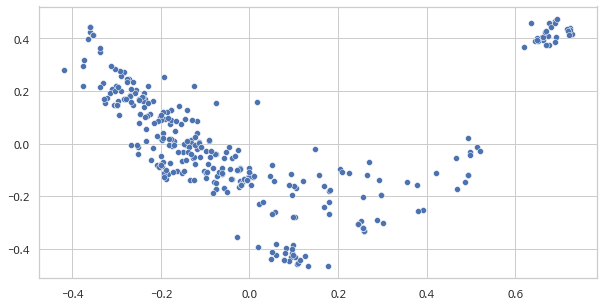

In [293]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x0, x1, data=df_kepco_esg)

## KMeans

## inertia

In [294]:
kmeans_per_n = [KMeans(n_clusters=n, random_state=42).fit(X) for n in range(1, 10)]
inertia_list = [model.inertia_ for model in kmeans_per_n]

그림 저장:  한전기술_intertia


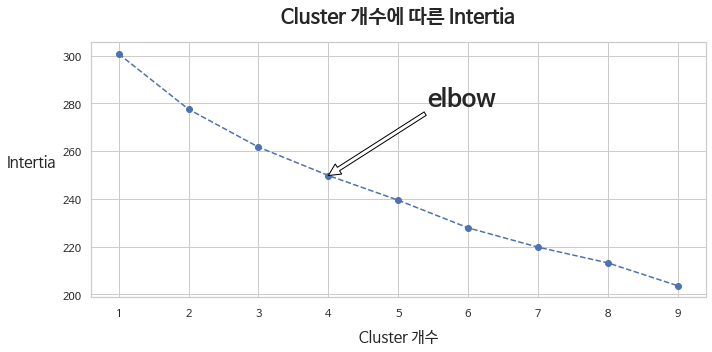

In [295]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 10), inertia_list, "bo--")
plt.annotate('elbow',
             xy=(4, inertia_list[3]),
             xytext=(0.6, .7),
             textcoords='figure fraction',
             fontsize=25, fontweight='bold',
             arrowprops=dict(facecolor='white', edgecolor='black')
            )
#title
title_style = {'fontsize': 20, 'fontweight': 'bold'}
plt.title('Cluster 개수에 따른 Intertia',pad=20,fontdict=title_style)

#set labels' style
plt.xlabel('Cluster 개수', fontsize=15, labelpad=10)
plt.ylabel('Intertia', fontsize=15, rotation=0, labelpad=30)

save_fig('한전기술_intertia')

In [296]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_n[1:]]

그림 저장:  한전기술_kmeans_silhouette


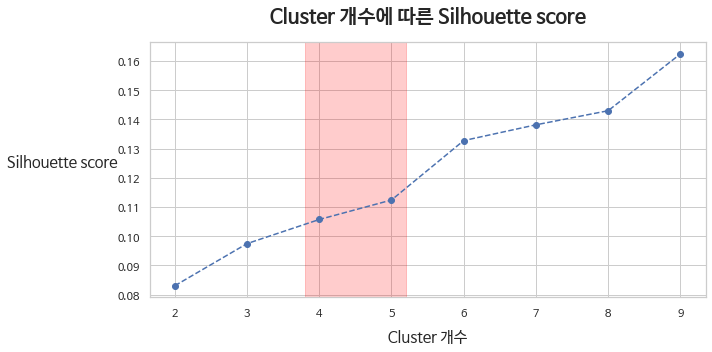

In [297]:
plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, "bo--")

#title
title_style = {'fontsize': 20, 'fontweight': 'bold'}
plt.title('Cluster 개수에 따른 Silhouette score',pad=20,fontdict=title_style)

#set labels' style
plt.xlabel('Cluster 개수', fontsize=15, labelpad=10)
plt.ylabel("Silhouette score", fontsize=15, rotation=0, labelpad=55)

plt.axvspan(3.8, 5.2, color='red', alpha=0.2)  

save_fig('한전기술_kmeans_silhouette')

그림 저장:  한전기술_kmeans_silhouette_diagram


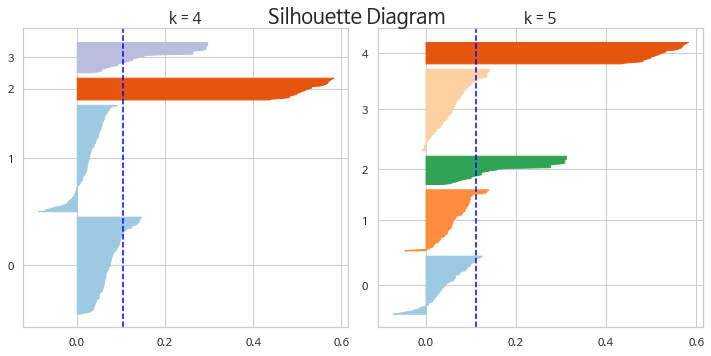

In [298]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import random

plt.figure(figsize=(10, 5))

for k in (4, 5):
    plt.subplot(1, 2, k-3).set_title(f'k = {k}', fontsize=15)
    plt.suptitle('Silhouette Diagram', fontsize=20)

    y_pred = kmeans_per_n[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X.toarray()) // 50
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        cmap = plt.get_cmap('tab20c')
        color = cmap(np.array(random.randrange(1, 15)))
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    plt.gca().set_xticks([0, 0.2, 0.4, 0.6])



    plt.axvline(x=silhouette_scores[k - 2], color="blue", linestyle="--")

  
save_fig('한전기술_kmeans_silhouette_diagram')

In [300]:
kmeans = KMeans(n_clusters=4, random_state=42, init ='k-means++')
kmeans.fit(X)

KMeans(n_clusters=4, random_state=42)

In [302]:
df_kepco_esg['kmeans'] = kmeans.labels_
df_kepco_esg.head()

,date,title,keyword,ESG,x0,x1,kmeans
4,2019,"한국테크놀로지, +3.37% 52주 신고가","[한국테크놀로지, 신고가, 한국테크놀로지, 신고가, 한국테크놀로지, 한전KPS, 우...",G,0.255876,-0.320493,3
37,2019,"한전기술, +12.47% VI 발동","[테마한전기술, 한전KPS, 우리기술, 에너토크, 보성파워텍, 에스앤더블류, 오르비...",G,0.391688,-0.252223,3
39,2019,"'한전기술' 5% 이상 상승, 최근 5일간 기관 대량 순매수","[개인들, 외국인, 그동안, 순매도, 거래비중, 외국인, 투자자들, 그래프, 외국인...",G,0.513419,-0.014898,3
40,2019,"한전KPS, +0.74% 52주 신고가","[한전KPS, 신고가, 한전KPS, 신고가, KPS, 한전KPS, 우리기술, 에너토...",G,0.259007,-0.334873,3
45,2019,"한수원, 한전기술.원자력환경공단 등과 원전 분야 창업 지원 `맞손`","[원자력환경공단, 화백컨벤션센터, 컨벤션, 경북창조경제혁신센터, 한국원자력환경공단,...",E,-0.162748,-0.104866,1


In [303]:
def get_top_keywords(num, label=kmeans.labels_):
    df = pd.DataFrame(X.todense()).groupby(label).mean() # cluster에 따라 TF-IDF vector 그룹화
    keywords = tfidf.get_feature_names_out() 
    for i,r in df.iterrows():
        print(f'\nCluster_{i}')
        print(','.join([keywords[t] for t in np.argsort(r)[-num:]])) #상위 num개수만큼의 keyword


get_top_keywords(10)


Cluster_0
김천시,공기업,중소기업,코로나,신재생,일자리,글로벌,프로젝트,활성화,에너지

Cluster_1
거래소,발전소,미래에셋증권,연구원,프로젝트,전문가,투자자,가능성,위원회,원자력

Cluster_2
변동성,매물대,제매물,가격대,수익률,거래비중,코스피업종,서비스업,cgv,외국인

Cluster_3
상승세,원자력,코스피,투자자,한전kps,신고가,비츠로테크,한국테크놀로지,순매도,외국인


In [304]:
def get_title_by_cluster(df, label, model):
  for i in set(label):
    #DBSCAN에서 -1,0은 noise 또는 clustering이 잘 안된 경우
    if model == 'dbscan':
      if(i == -1):
        continue
      else:
        print(f'\nCluster_{i}')
        temp = df[df[model] == i]
        for title in temp['title'][:3]:
          print(title, sep='  ')
    else:
      print(f'\nCluster_{i}')
      temp = df[df[model] == i]
      for title in temp['title'][:4]:
         print(title)

In [306]:
get_title_by_cluster(df_kepco_esg, kmeans.labels_, 'kmeans')


Cluster_0
한국전력기술 '제4회 대한민국 공공정책대상'에서 혁신성장 대상 수상
㈜무진기연, 해외 대형 원자력사업 수주
㈜무진기연, 10조 규모 글로벌 원자력사업에 납품한다
[이제는 스마트 에너지 혁신시대 - 공기업 시리즈 ④에너지] 한전 갈등관리부 ‘삼각 중재’로 평택 송전탑 5년 갈등 풀었다

Cluster_1
한수원, 한전기술.원자력환경공단 등과 원전 분야 창업 지원 `맞손`
[시론] 원전생태계 파괴, 더 이상은 안 된다
두산重 공장 가동률 추락
한수원 사장 "신한울 3 4호기는 '보류' 상태, 여러 가능성 있는 것"

Cluster_2
[ET투자뉴스]한전기술_거래비중 기관 24.89%, 외국인 17.26%
[ET투자뉴스]하나투어_거래비중 기관 21.67%, 외국인 20.71%
[ET투자뉴스]하나투어_상장주식수 대비 거래량은 1.16%로 적정수준
[ET투자뉴스]하나투어_상장주식수 대비 거래량은 1.28%로 적정수준

Cluster_3
한국테크놀로지, +3.37% 52주 신고가
한전기술, +12.47% VI 발동
'한전기술' 5% 이상 상승, 최근 5일간 기관 대량 순매수
한전KPS, +0.74% 52주 신고가


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


그림 저장:  한전기술_KMeans=4_scatterplot


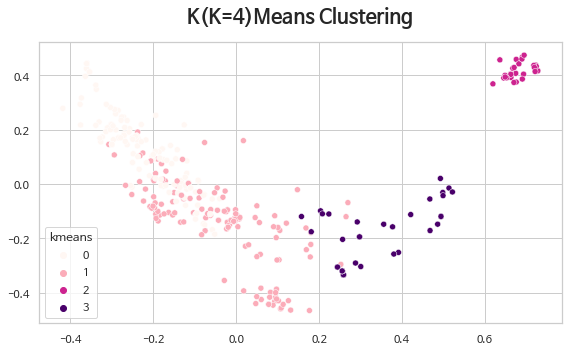

In [416]:
plt.figure(figsize=(8, 5))

sns.scatterplot(x0, x1, hue='kmeans', data=df_kepco_esg, palette='RdPu')
#title
title_style = {'fontsize': 20, 'fontweight': 'bold'}
plt.title('K(K=4)Means Clustering',pad=20,fontdict=title_style)

save_fig('한전기술_KMeans=4_scatterplot')

## DBCSAN

### NearestNeighbors

https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc 

https://stats.stackexchange.com/questions/88872/a-routine-to-choose-eps-and-minpts-for-dbscan

In [310]:
from sklearn.metrics.cluster import homogeneity_score,completeness_score,v_measure_score

for i in range (1,10,1):
  model= DBSCAN(eps=i*0.1, min_samples=10)
  model.fit(X)
  labels = model.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)
  print(f'\neps = {i*0.1}')
  print('Estimated number of clusters: %d' % n_clusters_)
  print('Estimated number of noise points: %d' % n_noise_)
  # print("Homogeneity: %0.3f" % homogeneity_score(y, labels))
  # print("Completeness: %0.3f" % completeness_score(y, labels))
  # print("V-measure: %0.3f" %v_measure_score(y, labels))


eps = 0.1
Estimated number of clusters: 0
Estimated number of noise points: 333

eps = 0.2
Estimated number of clusters: 0
Estimated number of noise points: 333

eps = 0.30000000000000004
Estimated number of clusters: 0
Estimated number of noise points: 333

eps = 0.4
Estimated number of clusters: 1
Estimated number of noise points: 323

eps = 0.5
Estimated number of clusters: 1
Estimated number of noise points: 315

eps = 0.6000000000000001
Estimated number of clusters: 2
Estimated number of noise points: 293

eps = 0.7000000000000001
Estimated number of clusters: 2
Estimated number of noise points: 288

eps = 0.8
Estimated number of clusters: 5
Estimated number of noise points: 255

eps = 0.9
Estimated number of clusters: 7
Estimated number of noise points: 190


In [311]:
NN_per_n = [NearestNeighbors(n_neighbors=n, n_jobs= -1).fit(X) for n in range(1, 10)]
# inertia_list = [model.inertia_ for model in kmeans_per_n]

In [312]:
nn = NearestNeighbors(n_neighbors=4, n_jobs=-1).fit(X)

In [313]:
distances, indices = nn.kneighbors(X)

그림 저장:  한전기술_eps


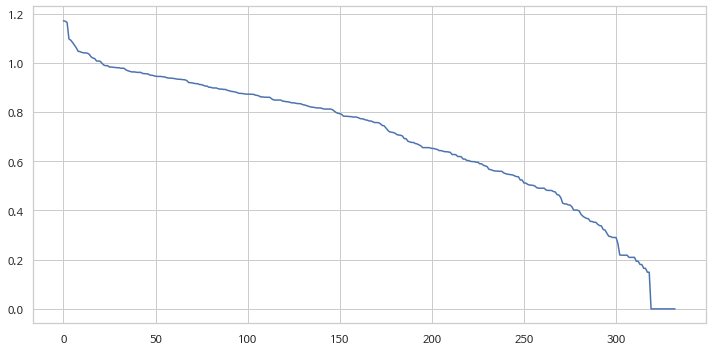

In [324]:
plt.figure(figsize=(10, 5))
distance_desc = sorted(distances[:,3], reverse=True)
plt.plot(distance_desc)
#optimal epsilon 커브 많이 되는 지점에

save_fig('한전기술_eps')

In [331]:
kneeloc = KneeLocator(range(1,len(distance_desc)+1),  #x values
                      distance_desc, # y values
                      S=1.0, #parameter suggested from paper
                      curve="convex", #parameter from figure
                      direction="decreasing") #parameter from figure

그림 저장:  한전기술_eps_knee


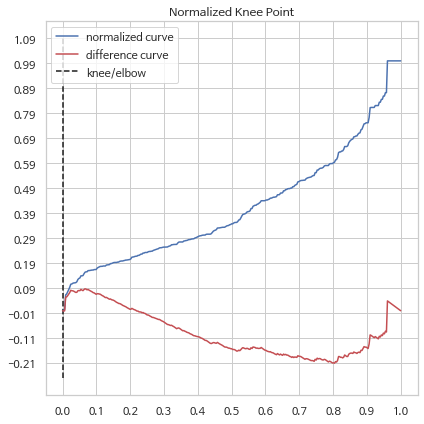

In [332]:
kneeloc.plot_knee_normalized()
save_fig('한전기술_eps_knee')

In [333]:
kneeloc.knee_y

1.1704787646997958

In [381]:
dbscan = DBSCAN(eps=0.5, min_samples=10, metric = "cosine")
#1.1 떨어진 거리 같은 cluster
#한 cluster에 적어도 10개의 sample이 모여야 함.
res = dbscan.fit_predict(X)

In [382]:
df_kepco_esg['dbscan'] = dbscan.labels_
df_kepco_esg.head()

,date,title,keyword,ESG,x0,x1,kmeans,dbscan
4,2019,"한국테크놀로지, +3.37% 52주 신고가","[한국테크놀로지, 신고가, 한국테크놀로지, 신고가, 한국테크놀로지, 한전KPS, 우...",G,0.255876,-0.320493,3,0
37,2019,"한전기술, +12.47% VI 발동","[테마한전기술, 한전KPS, 우리기술, 에너토크, 보성파워텍, 에스앤더블류, 오르비...",G,0.391688,-0.252223,3,0
39,2019,"'한전기술' 5% 이상 상승, 최근 5일간 기관 대량 순매수","[개인들, 외국인, 그동안, 순매도, 거래비중, 외국인, 투자자들, 그래프, 외국인...",G,0.513419,-0.014898,3,0
40,2019,"한전KPS, +0.74% 52주 신고가","[한전KPS, 신고가, 한전KPS, 신고가, KPS, 한전KPS, 우리기술, 에너토...",G,0.259007,-0.334873,3,0
45,2019,"한수원, 한전기술.원자력환경공단 등과 원전 분야 창업 지원 `맞손`","[원자력환경공단, 화백컨벤션센터, 컨벤션, 경북창조경제혁신센터, 한국원자력환경공단,...",E,-0.162748,-0.104866,1,0


In [383]:
print('DBSCAN_Cluster 개수: ' + str(len(df_kepco_esg['dbscan'].unique())))

DBSCAN_Cluster 개수: 6


In [384]:
explode = []
i = 0
for _ in range(len(df_kepco_esg['dbscan'].unique())):
  explode.append(i)
  i += 0.2

그림 저장:  한전_DBSCAN_cluster_pie


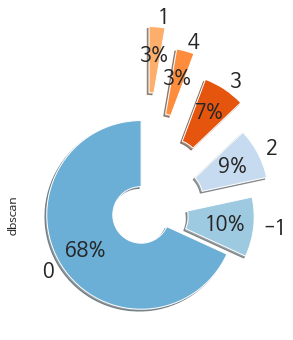

In [387]:
wedgeprops ={'width': 0.7, 'edgecolor': 'w'}

cmap = plt.get_cmap('tab20c')
colors = cmap(np.array(range(1, 40)))


df_kepco_esg['dbscan'].value_counts().plot.pie(radius=1, colors=colors, startangle=90, pctdistance=0.7, explode=explode,
                wedgeprops=wedgeprops, autopct='%1.0f%%', shadow=True, figsize=(7, 5), fontsize=20)

save_fig('한전_DBSCAN_cluster_pie')

In [388]:
#@title 기본 제목 텍스트
get_top_keywords(10, label=dbscan.labels_)


Cluster_-1
거래소,폐기물,경쟁력,거래일,프로젝트,코스피,서비스,에너지,공매도,가능성

Cluster_0
한전kps,코로나,위원회,전문가,발전소,외국인,활성화,프로젝트,원자력,에너지

Cluster_1
테마주,프로젝트,에너지,사무소,코스피,외국인,기대감,투자자,거래소,코스닥

Cluster_2
변동성,매물대,제매물,가격대,수익률,거래비중,코스피업종,서비스업,cgv,외국인

Cluster_3
투자자들,거래일,비덴트,nft,카카오게임즈,hmm,엠클럽,테마주,투자자,미래에셋증권

Cluster_4
신재생,원자력,글로벌,업무협약,에너지,프로젝트,플랫폼,데이터,엔지니어링,디지털


In [389]:
get_title_by_cluster(df_kepco_esg, dbscan.labels_, 'dbscan')


Cluster_0
한국테크놀로지, +3.37% 52주 신고가
한전기술, +12.47% VI 발동
'한전기술' 5% 이상 상승, 최근 5일간 기관 대량 순매수

Cluster_1
美中분쟁 국내 경기부진 영향 지역상장사 8월시총 소폭 감소
대구 경북 상장사 1월 시총, 5조 늘어 55조
대구 경북지역 상장법인 시총 5개월 만에 ‘반등’

Cluster_2
[ET투자뉴스]한전기술_거래비중 기관 24.89%, 외국인 17.26%
[ET투자뉴스]하나투어_거래비중 기관 21.67%, 외국인 20.71%
[ET투자뉴스]하나투어_상장주식수 대비 거래량은 1.16%로 적정수준

Cluster_3
NFT 메타버스 ESG 올라탄 테마株 훨훨 날았다
[주식초고수는 지금] 메타버스 NFT 투자 가속화 다날 매수 매도 1위
[주식초고수는 지금] 가상화폐 NFT 올라탄 비덴트 거래 활발

Cluster_4
ICT융합 사이언스밸리 경북 5대 지역 '과학산업 메카'로 키운다
한국전력기술과 한국도로공사, 스마트건설과 디지털엔지니어링 기술협력 업무협약 체결
한국전력기술, 한국도로공사와 스마트건설 디지털엔지니어링 기술협력


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


그림 저장:  한전기술_ESG_scatterplot


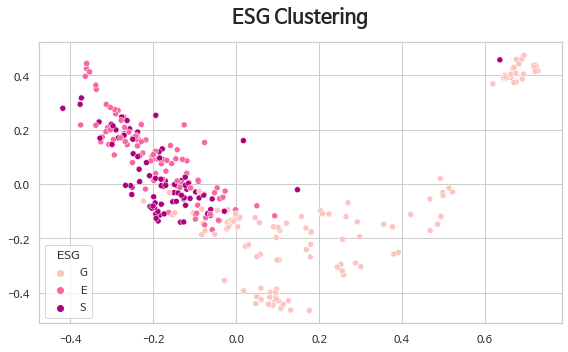

In [414]:
plt.figure(figsize=(8, 5))

sns.scatterplot(x0, x1, hue='ESG', data=df_kepco_esg, palette="RdPu")
#title
title_style = {'fontsize': 20, 'fontweight': 'bold'}
plt.title('ESG Clustering',pad=20,fontdict=title_style)

# for i, txt in enumerate(kepco_esg_keyword_list):
#   plt.annotate(txt, (x0[i], x1[i]))

save_fig('한전기술_ESG_scatterplot')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


그림 저장:  한전기술_DBSCAN_scatterplot


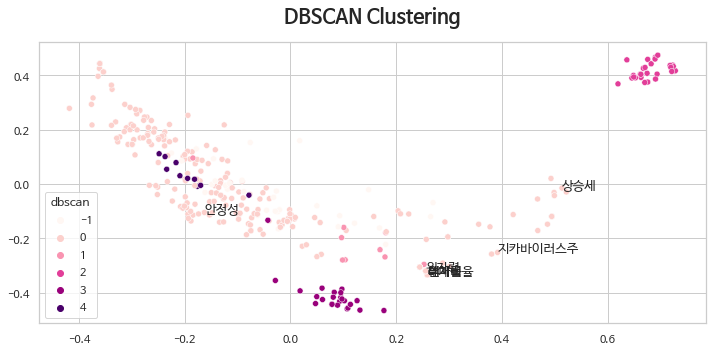

In [480]:
plt.figure(figsize=(10, 5))

sns.scatterplot(x0, x1, hue='dbscan', data=df_kepco_esg, palette="RdPu")
#title
title_style = {'fontsize': 20, 'fontweight': 'bold'}
plt.title('DBSCAN Clustering',pad=20,fontdict=title_style)


for i, txt in enumerate(df_kepco_esg['keyword'].values.tolist()[100][:7]):
  plt.annotate(txt, (x0[i], x1[i]), fontsize=13)


save_fig('한전기술_DBSCAN_scatterplot')